In [15]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import cv2
import math

import utils

mnist_path = 'data/mnist-zoomed-to-bounds.npy'
model_path = 'data/model'

[[ 683 1650  756 1720]
 [ 680 1578  754 1649]
 [ 677 1506  751 1576]
 [ 674 1434  749 1504]
 [1289 1645 1360 1714]
 [1288 1572 1359 1643]
 [1287 1500 1359 1571]
 [1286 1429 1358 1498]
 [1890 1566 1960 1637]
 [1891 1638 1960 1708]
 [1889 1495 1959 1565]
 [1889 1424 1959 1494]
 [2483 1559 2554 1630]
 [2484 1631 2555 1701]
 [2483 1488 2553 1558]
 [2482 1416 2553 1486]
 [3095 1625 3166 1696]
 [3093 1553 3164 1623]
 [3091 1481 3162 1550]
 [3087 1409 3159 1478]
 [3669 1621 3734 1690]
 [3667 1549 3731 1618]
 [3666 1478 3729 1547]
 [3662 1408 3728 1476]]
(24, 4)
(3024, 4032)
(3024, 4032, 1)


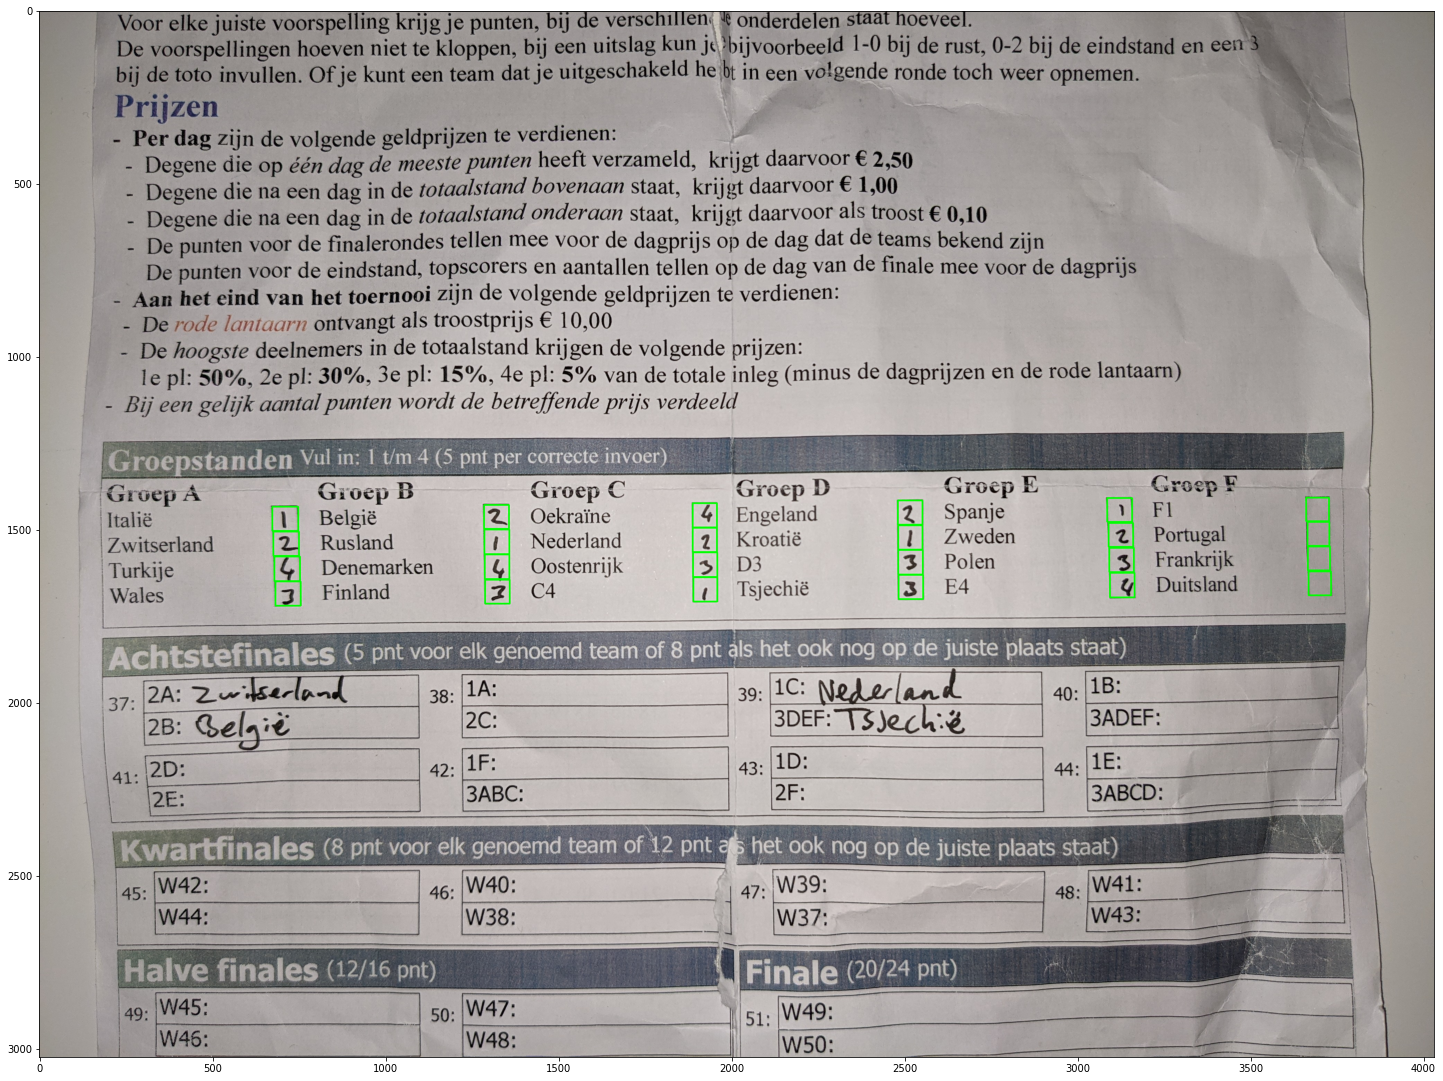

In [24]:
img = cv2.imread('/home/dan/Downloads/PXL_20210705_205441527.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
thresh = 255 - thresh

blur=cv2.GaussianBlur(thresh, (3, 3), 1)
canny=cv2.Canny(blur, 5, 25)

contours, hierarchy = cv2.findContours(
    image=canny, 
    mode=cv2.RETR_TREE,
    method=cv2.CHAIN_APPROX_NONE
)
contours = [c for c in contours if cv2.contourArea(c) > 4000]

# This is too naive. One way to improve could be using width/height ratio to filter
# 1/1 would be square = group stage. 2/1 would be landscape rect = match entry, etc. 
filtered = []
for c in contours:
    o = 20
    area = cv2.contourArea(c)
    if area < 2000 or area > 30000: continue
    perimeter = cv2.arcLength(c, True)
    approximation = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(approximation) > 100: continue
    x, y, w, h = cv2.boundingRect(approximation)
    if w >= h + o or w <= h - o: continue
    filtered.append([x, y, x + w, y + h])


# print(np.array(filtered).shape)

# img = cv2.drawContours(
#     image=img,
#     contours=filtered,
#     contourIdx=-1,
#     color=(0, 255, 0),
#     thickness=1,
#     lineType=cv2.LINE_AA
# )

# Naive duplicate filtering... Is there a better openCV'nic way?
rects = []
for r in filtered:
    rel_tol = 0.02
    existing = [er for er in rects if math.isclose(r[0], er[0], rel_tol=rel_tol) and math.isclose(r[1], er[1], rel_tol=rel_tol)]
    if len(existing): continue
    rects.append(r)
    cv2.rectangle(img, (r[0], r[1]), (r[2], r[3]), (0, 255, 0), 3)

rects = np.asarray(rects)
    
# Sort from left to right top to bottom
# print('hai', rects[rects[:1].argsort()])
print(rects)
print(np.asarray(rects).shape)

thresh = np.asarray(thresh)
print(thresh.shape)

# thresh = thresh.reshape(*thresh.shape, 1)
thresh = np.expand_dims(thresh, axis=2)

thresh = thresh / 255

print(thresh.shape)

plt.figure(figsize=(25, 25))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

2021-07-05 23:11:44.862851: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-05 23:11:47.470749: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-05 23:11:47.470784: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dell-taco): /proc/driver/nvidia/version does not exist


[]

In [3]:
# Use cached augmented data if it exists
if os.path.isfile(mnist_path) is False:
    print("Normalizing mnist data set")
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test  = x_test  / 255.0
    
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test  = x_test.reshape(x_test.shape[0], 28, 28, 1)

    x_train = np.array([utils.zoom_to_bounds(img_array) for img_array in x_train])
    x_test  = np.array([utils.zoom_to_bounds(img_array) for img_array in x_test])

    to_save =  np.array( ([x_train, y_train], [x_test, y_test]) )
    np.save(mnist_path, to_save)
else:
    print("Using cached mnist data set")
    (x_train, y_train), (x_test, y_test) = np.load(mnist_path, allow_pickle=True)

Using cached mnist data set


In [6]:
# Not overwriting if already exists!
if os.path.isdir(model_path) is False:
    print("Training model")
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=12)
    model.save(model_path)
else:
    print("Loading cached model")
    model = tf.keras.models.load_model(model_path)
    
model.evaluate(x_test,  y_test, verbose=2)

Loading cached model
313/313 - 0s - loss: 0.0782 - accuracy: 0.9773


[0.07823777198791504, 0.9772999882698059]

In [7]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [8]:
pngs = sorted(glob("data/pngs/*.png"))
def load_image(path):
    image     = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale", target_size=(28,28), interpolation='nearest')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    return input_arr / 255

actual_data = [load_image(png) for png in pngs]
actual_data = np.array(actual_data)
actual_data.shape

(45, 28, 28, 1)

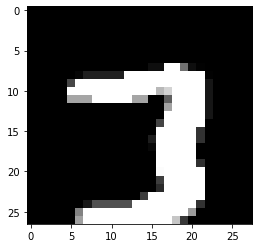

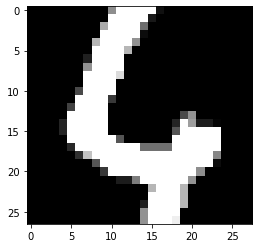

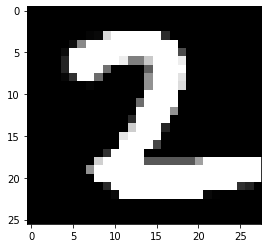

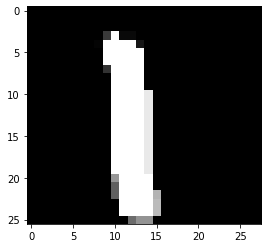

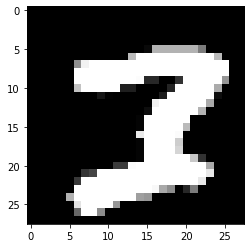

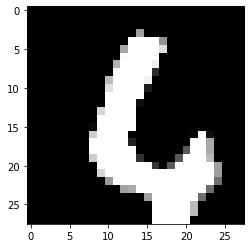

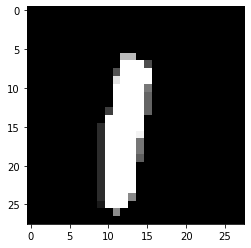

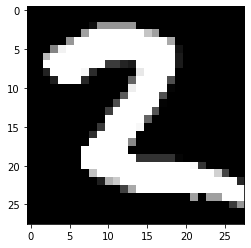

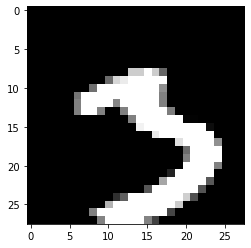

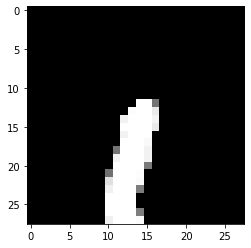

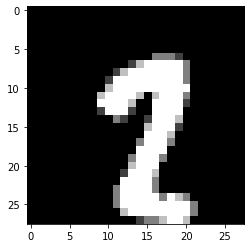

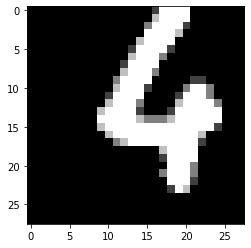

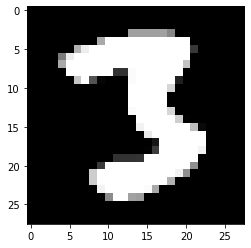

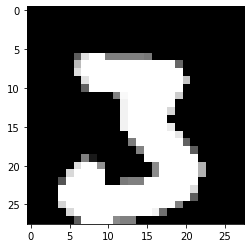

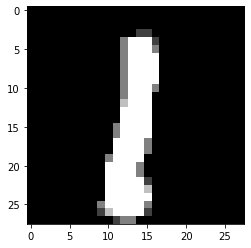

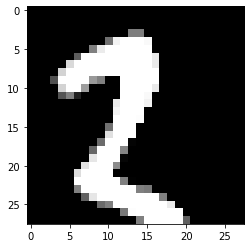

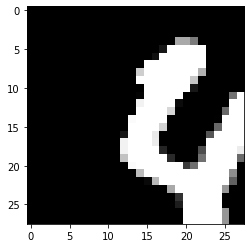

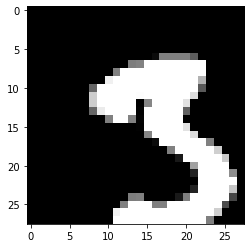

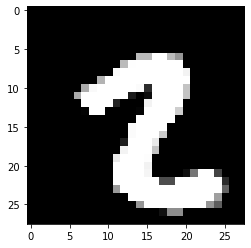

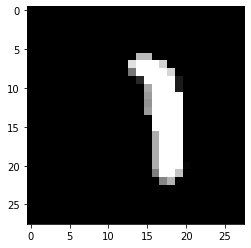

In [26]:
group_stage = []
for r in rects:
    cropped = tf.image.crop_to_bounding_box(
        thresh, r[1], r[0], r[3] - r[1], r[2] - r[0]
    )
    cropped = tf.image.central_crop(
        cropped, 0.8
    )
    resized = tf.image.resize(
        cropped, (28,28), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=True
    )
    
    if len(np.nonzero(resized)[0]) < 3: continue
    
    plt.imshow(resized, cmap="gray")
    plt.show()
    group_stage.append(resized)

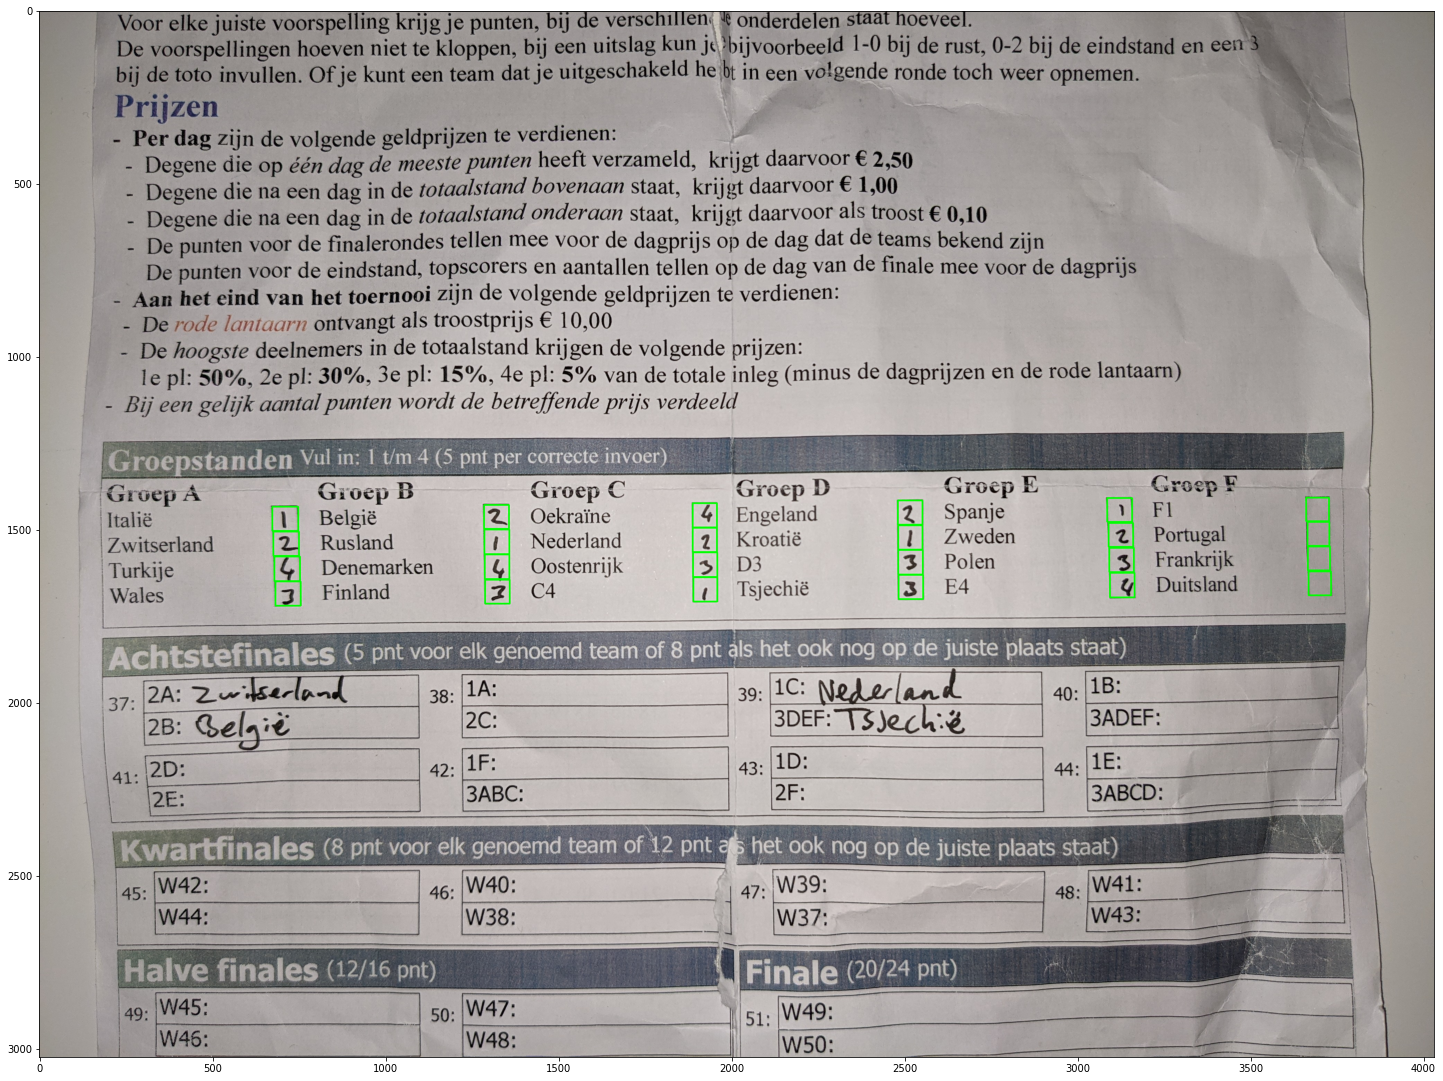

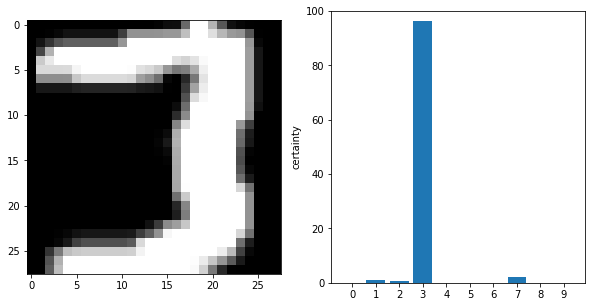

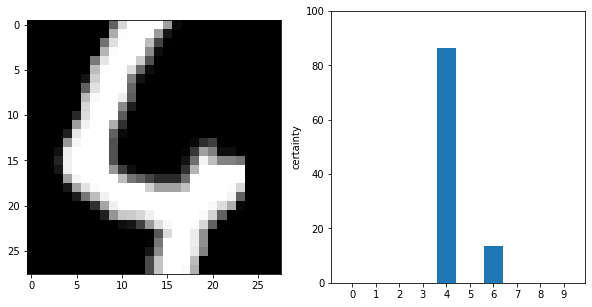

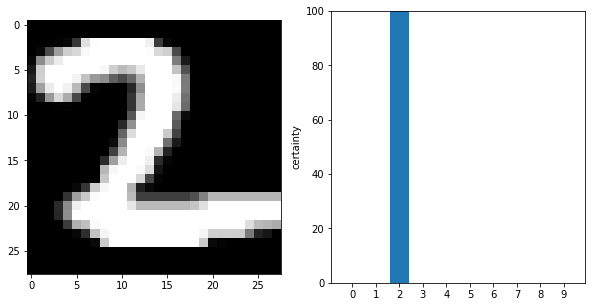

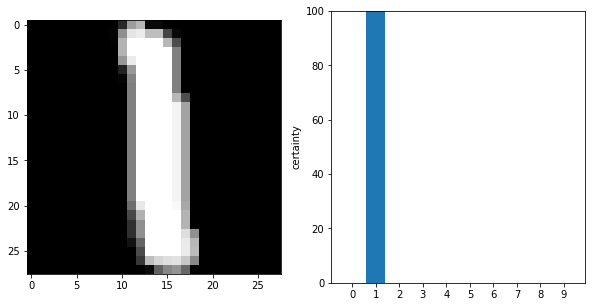

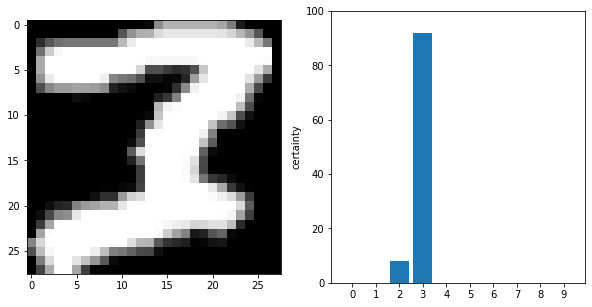

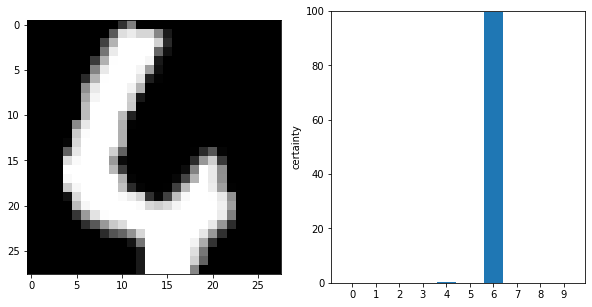

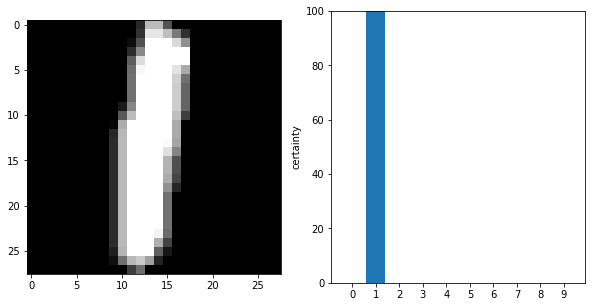

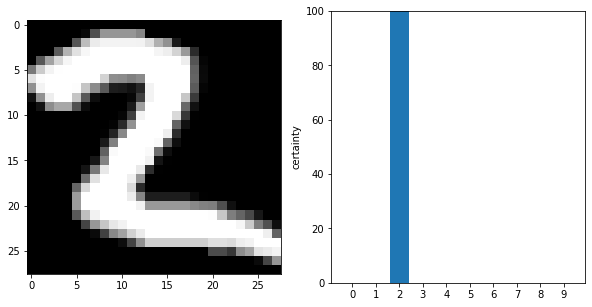

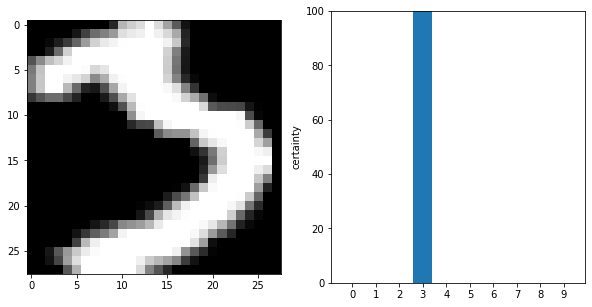

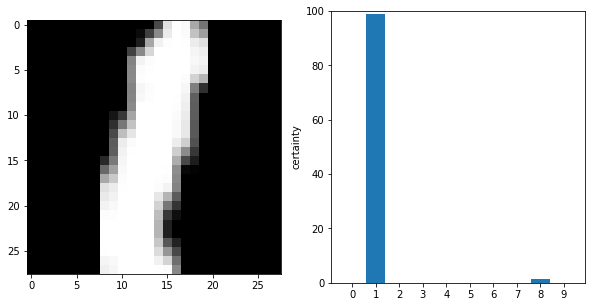

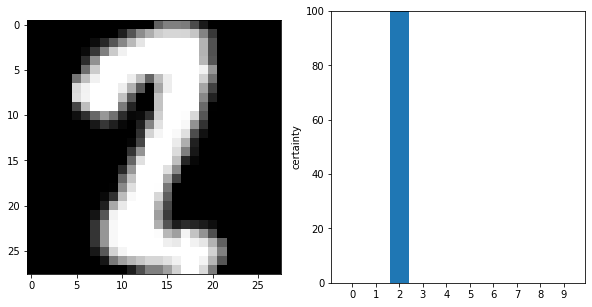

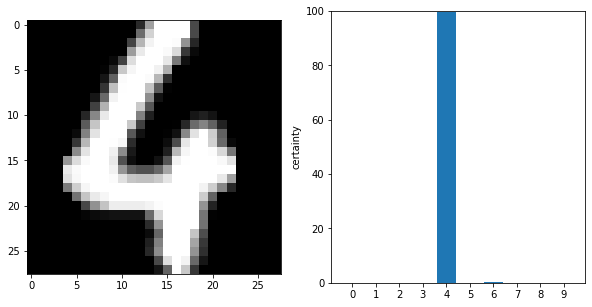

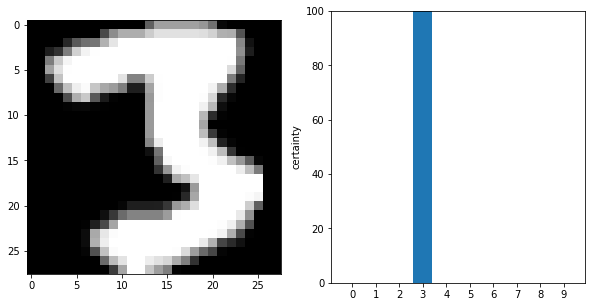

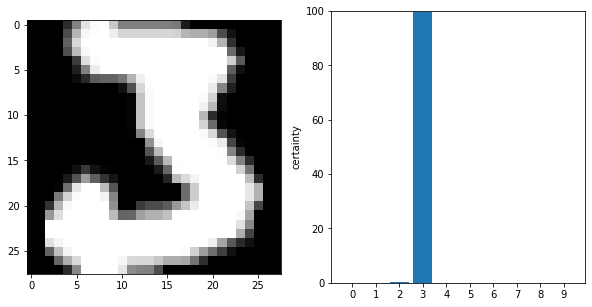

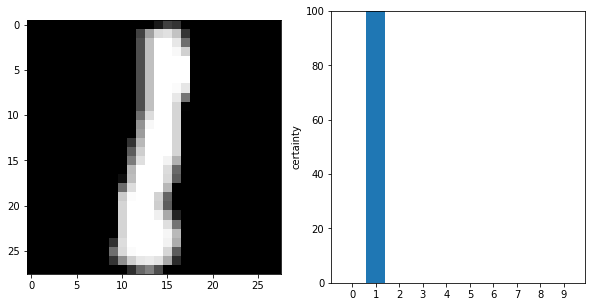

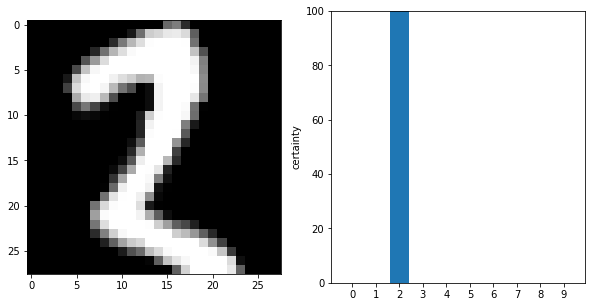

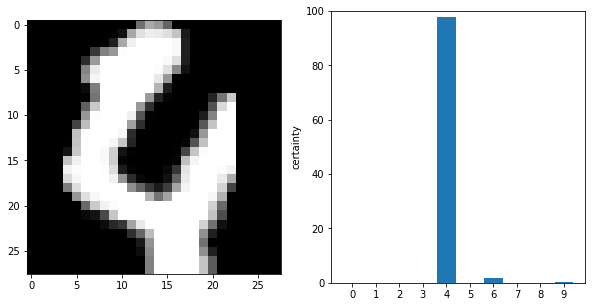

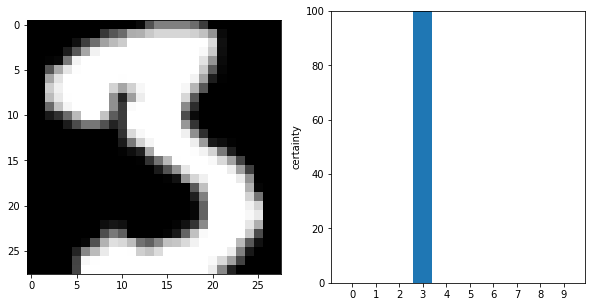

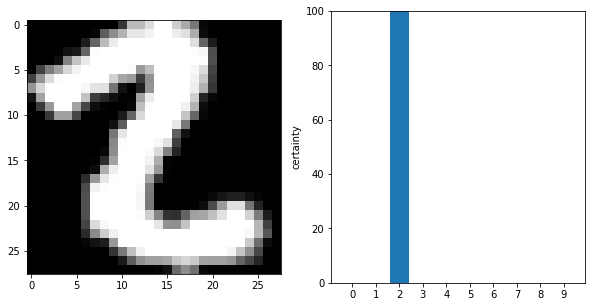

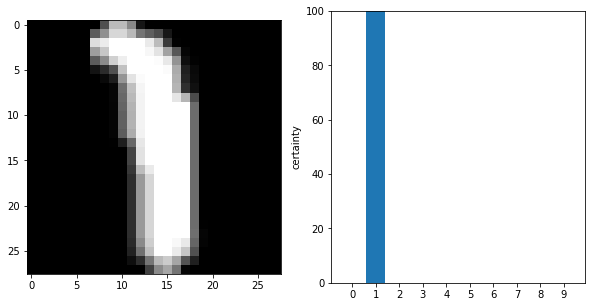

In [27]:
plt.figure(figsize=(25, 25))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
data = np.array([utils.zoom_to_bounds(img_array) for img_array in group_stage])
predictions = probability_model(data) * 100
for i, d in enumerate(data):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(d, cmap="gray")
    ax2.bar(x=range(0, 10), height=predictions[i], tick_label=range(0, 10))
    ax2.set(ylabel="certainty", ylim=(0, 100))
